Team: CS24MTECH11008 - Sakshi Badole, CS24MTECH11010 - Laveena Herman, CS24MTECH14015 - S Anjana Shankar

# Identifying outliers in data with the help of VAE




Import libraries

In [1]:
import numpy as np # importing the required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score
import random

Load dataset

In [2]:
data_frame = pd.read_csv("/content/data.csv") # loading the dataset into memory
data_frame.head() # printing few samples in dataset

,cov1,cov2,cov3,cov4,cov5,cov6,cov7,sal_pur_rat,igst_itc_tot_itc_rat,lib_igst_itc_rat
0,0.997797,0.999888,0.215934,0.196713,0.000000,0.955616,0.998810,-0.032581,1.761759,-0.054329
1,0.994004,0.979902,-0.337135,-0.248634,0.000000,0.640812,0.553918,-0.032026,-0.629311,-0.053516
2,0.947603,0.455667,0.001743,0.128610,-0.004054,-0.162069,0.960601,-0.030209,1.535697,-0.054215
3,0.396577,0.919933,0.496451,0.576824,-0.340718,0.802363,0.673710,-0.032058,0.449160,-0.054126
4,0.999893,0.327615,0.700477,0.315601,0.000000,0.300785,0.979009,-0.032224,1.762049,-0.054330


Data frame -> Numpy

In [3]:
data_numpy = data_frame.select_dtypes(include=[np.number]).values  # converting the dataset to numpy

Seed set

In [4]:
# setting seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Saving input data properties

In [5]:
# saving the data properties
num_samples = data_numpy.shape[0]
num_features = data_numpy.shape[1]

Standardization

In [6]:
def standardize_data(data): # function to standardize the input data
  scaler = StandardScaler()   # using standard scaler to standardize the data
  data_scaled = scaler.fit_transform(data)
  return data_scaled # return the standardized data

data_scaled = standardize_data(data_numpy) # function call to standardize data
data_scaled

array([[ 0.30302306,  0.58865765,  0.00409293, ..., -0.03259429,
         1.7624945 , -0.05435166],
       [ 0.27492017,  0.50702407, -1.35139127, ..., -0.032039  ,
        -0.62957391, -0.05353871],
       [-0.06885229, -1.63424368, -0.52085449, ..., -0.03022127,
         1.53633734, -0.05423742],
       ...,
       [ 0.31933995, -0.42477184, -1.03891695, ..., -0.03293717,
        -0.51792251, -0.05377676],
       [ 0.31928377,  0.57799265, -0.03664445, ..., -0.03300002,
        -1.03153787, -0.0430471 ],
       [ 0.31914088, -1.20108459, -0.89973974, ..., -0.03267062,
        -1.04314323, -0.03578275]])

Numpy Array -> Tensor

In [7]:
data_tensor = torch.tensor(data_scaled, dtype=torch.float32) # converting data to tensor

Variational Auto Encoder Model

In [8]:
# defining the Variational Auto Encoder model which will compress data to a lower dimensional space

class VAE(nn.Module):
    def __init__(self, input_dimension, latent_dimension):     # function which initializes the VAE model, takes input and latent dimensions as parameters
        super(VAE, self).__init__() # adding the in built defined version of VAE

        self.encoder = nn.Sequential(
            nn.Linear(input_dimension, 128),  # projects the inputs to a dimension of 128
            nn.ReLU(),  # relu activation
            nn.Linear(128, 64),  # convert dimension of 128 to 64
            nn.ReLU(), # relu activation
            nn.Linear(64, latent_dimension * 2)  # outputs mean and log variance of the latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, 64), # take the latent space representations and convert to a dimension of 64
            nn.ReLU(),  # relu activation
            nn.Linear(64, 128),  # converts dimension of 64 to 128
            nn.ReLU(), # relu activation
            nn.Linear(128, input_dimension), # converts dimension of 128 to input dimension
            nn.Sigmoid() # sigmoid activation
        )

    def encode(self, input): # function which encodes the input values
        input_encoded = self.encoder(input)  # pass to encoder to obtain compressed representation
        mean, log_variance = torch.chunk(input_encoded, 2, dim=1)  # split encoded representation into mean and log variance of the latent space
        return mean, log_variance  # return mean and log variance

    def reparameterize(self, mean, log_variance): # function which applies reparameterization trick to sample from the latent space
        standard_deviation = torch.exp(0.5 * log_variance)  # computing standard deviation from log variance
        epsilon = torch.randn_like(standard_deviation)  # get noise using normal distribution
        return mean + epsilon * standard_deviation   # add the noise and generate the new latent representation vector

    def forward(self, input):  # function which implements the forward pass of the VAE
        mean, log_variance = self.encode(input) # split encoded representation into mean and log variance
        z = self.reparameterize(mean, log_variance)  # apply reparameterization trick to sample from the latent space
        input_decoded = self.decoder(z)  # decode the latent vector to reconstruct the input
        return input_decoded, mean, log_variance   # return reconstructed input, mean, and log variance


Train using VAE

In [9]:
def train_using_vae_and_compress_dimension(input_tensor, num_features, latent_dim, epochs, verbose = False, batch_size=64): # function which takes the input and trains using VAE to compress the dimension
    #setting seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    vae = VAE(input_dimension=num_features, latent_dimension=latent_dim).to(device) # creating an instance of the VAE model
    optimizer = optim.Adam(vae.parameters(), lr=0.001) # adam optimizer used
    loss_function = nn.MSELoss() # mean squared loss is set to use for reconstruction loss

    dataloader = DataLoader(TensorDataset(input_tensor), batch_size=batch_size, shuffle=False) # loading the data as batches

    total_recon_loss = 0 # to track total reconstruction loss
    total_kl_div = 0  # to track total KL Divergence
    total_loss = 0 # to track total loss

    for epoch in range(epochs): # for each epoch
        epoch_loss = 0
        epoch_recon_loss = 0
        epoch_kl_div = 0
        for batch in dataloader: # for each batch
            input_batch = batch[0].to(device)
            optimizer.zero_grad() # gradient of optimizer initialized to zero
            input_reconstructed, mean, log_variance = vae(input_batch) # training the input batch using vae

            beta = 1.5
            # VAE loss = Reconstruction Loss + KL Divergence
            reconstruction_loss = loss_function(input_reconstructed, input_batch) # reconstruction loss calculated
            kl_divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) / input_batch.size(0) # kl divergence calculated
            loss = reconstruction_loss + beta * kl_divergence # total loss calculated as the sum of reconstruction loss as well as kl divrgence

            loss.backward() # back propagation done
            optimizer.step()

            epoch_recon_loss += reconstruction_loss.item()
            epoch_kl_div += kl_divergence.item() # loss added to the loss in epoch
            epoch_loss += loss.item()

        if(verbose == True): # printing epoch loss if verbose is true
          print(f"Epoch {epoch}, Loss: {epoch_loss}")

        total_loss += epoch_loss # total loss calculated
        total_recon_loss += epoch_recon_loss
        total_kl_div += epoch_kl_div

    avg_loss = total_loss / epochs # average loss calculated
    avg_recon_loss = total_recon_loss / epochs  # Average reconstruction loss
    avg_kl_div = total_kl_div / epochs # average kl divergence

    return vae, avg_loss, avg_recon_loss, avg_kl_div # returning the vae model as well as the average losses

K-Means Clustering

In [10]:
def apply_kmeans_clustering(num_clusters, latent_representations): # function that applies k-means clustering to the data

  best_kmeans = None
  best_inertia = float("inf")

  for _ in range(5):  # run multiple times to stabilize clusters
      kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
      clusters = kmeans.fit_predict(latent_representations)
      if kmeans.inertia_ < best_inertia:
          best_inertia = kmeans.inertia_  # getting best kmeans out of 5
          best_kmeans = kmeans

  clusters = best_kmeans.predict(latent_representations) # finding the clusters
  return kmeans, clusters # return kmeans and clusters

Identifying Boundary Outliers

In [11]:
def identify_boundary_outliers(latent_representations, kmeans, threshold_percentage_boundary): # function which identifies boundary outliers
  distances = np.min(cdist(latent_representations, kmeans.cluster_centers_, 'euclidean'), axis=1) # calculating distances from cluster centres

  boundary_threshold = np.percentile(distances, threshold_percentage_boundary)   # define threshold for boundary points
  boundary_outliers = distances > boundary_threshold # getting the outliers according to the threshold

  return boundary_outliers

Identifying Small Cluster Outliers

In [12]:
def identify_small_cluster_outliers(clusters): # function which identifies small cluster outliers
  cluster_sizes = np.bincount(clusters) # getting the cluster sizes
  small_cluster_threshold = 0.05 * len(data_numpy)  # define threshold for small clusters
  small_clusters = np.where(cluster_sizes < small_cluster_threshold)[0] # finding out the small clusters

  small_cluster_outliers = np.isin(clusters, small_clusters)
  return small_cluster_outliers

Identifying Outliers

In [13]:
def identify_outliers(latent_representations, kmeans, clusters): # function which identifies the outliers

  boundary_outliers = identify_boundary_outliers(latent_representations, kmeans, 95)   # Identify Boundary Points in Large Clusters

  small_cluster_outliers = identify_small_cluster_outliers(clusters)   # Identify Small Cluster Points (clusters with few points)

  print("Number of boundary outliers: ", len(np.where(boundary_outliers)[0])) # logging the outliers
  print("Boundary outlier indices: ", np.where(boundary_outliers)[0])
  print("Number of small cluster outliers: ", len(np.where(small_cluster_outliers)[0]))
  print("Small cluster outlier indices: ", np.where(small_cluster_outliers)[0])

  outliers_combined = boundary_outliers | small_cluster_outliers   # combine both types of outliers

  outlier_indices = np.where(outliers_combined)[0]   # get indices of outliers
  print(f"Total Number of outliers detected: {len(outlier_indices)}")
  print(f"Outlier Indices: {outlier_indices}")

  outlier_data = data_frame.iloc[outlier_indices]   # show outlier data points

  return outlier_indices, boundary_outliers, small_cluster_outliers


Experimenting with different dimensions for dimension reduction using VAE

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cuda gpu if available, else cpu
latent_dims = [2, 3, 4, 5, 6, 7] # defining the different latent dimensions to try
vae_models = {}
recon_losses = []
epochs = 50  # defining number of epochs

for dimension in latent_dims: # for each dimension in latent dimensions
    print(f"Training VAE with latent dimension {dimension}...")
    vae, avg_loss, avg_recon_loss, avg_kl_div = train_using_vae_and_compress_dimension(data_tensor, num_features, dimension, epochs) # train using vae
    vae_models[dimension] = vae # saving the vae model
    recon_losses.append(avg_recon_loss) # saving the loss for the dimension
    print(f"{epochs} epochs done. Training complete for dimension = {dimension}, Avg Reconstruction Loss: {avg_recon_loss:.4f}")


Training VAE with latent dimension 2...
50 epochs done. Training complete for dimension = 2, Avg Reconstruction Loss: 19.0008
Training VAE with latent dimension 3...
50 epochs done. Training complete for dimension = 3, Avg Reconstruction Loss: 18.9946
Training VAE with latent dimension 4...
50 epochs done. Training complete for dimension = 4, Avg Reconstruction Loss: 18.9995
Training VAE with latent dimension 5...
50 epochs done. Training complete for dimension = 5, Avg Reconstruction Loss: 18.9901
Training VAE with latent dimension 6...
50 epochs done. Training complete for dimension = 6, Avg Reconstruction Loss: 18.9957
Training VAE with latent dimension 7...
50 epochs done. Training complete for dimension = 7, Avg Reconstruction Loss: 18.9897


Plotting graph comparing reconstruction loss of different latent dimensions

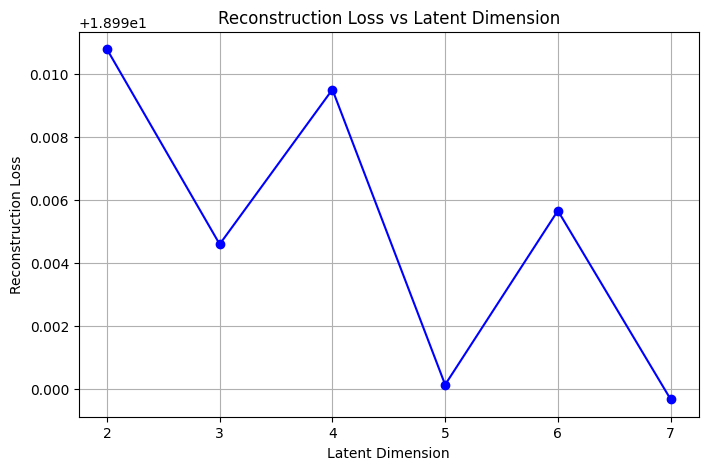

In [15]:
# plotting reconstruction loss vs latent dimension
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, recon_losses, marker="o", linestyle="-", color="b")
plt.xlabel("Latent Dimension")
plt.ylabel("Reconstruction Loss")
plt.title("Reconstruction Loss vs Latent Dimension")
plt.grid(True)
plt.show()

Dimensions 3, 5 and 7 have lesser reconstruction errors. Dimension 2 has high reconstruction error.

Plotting t-sne plot of different latent dimensions

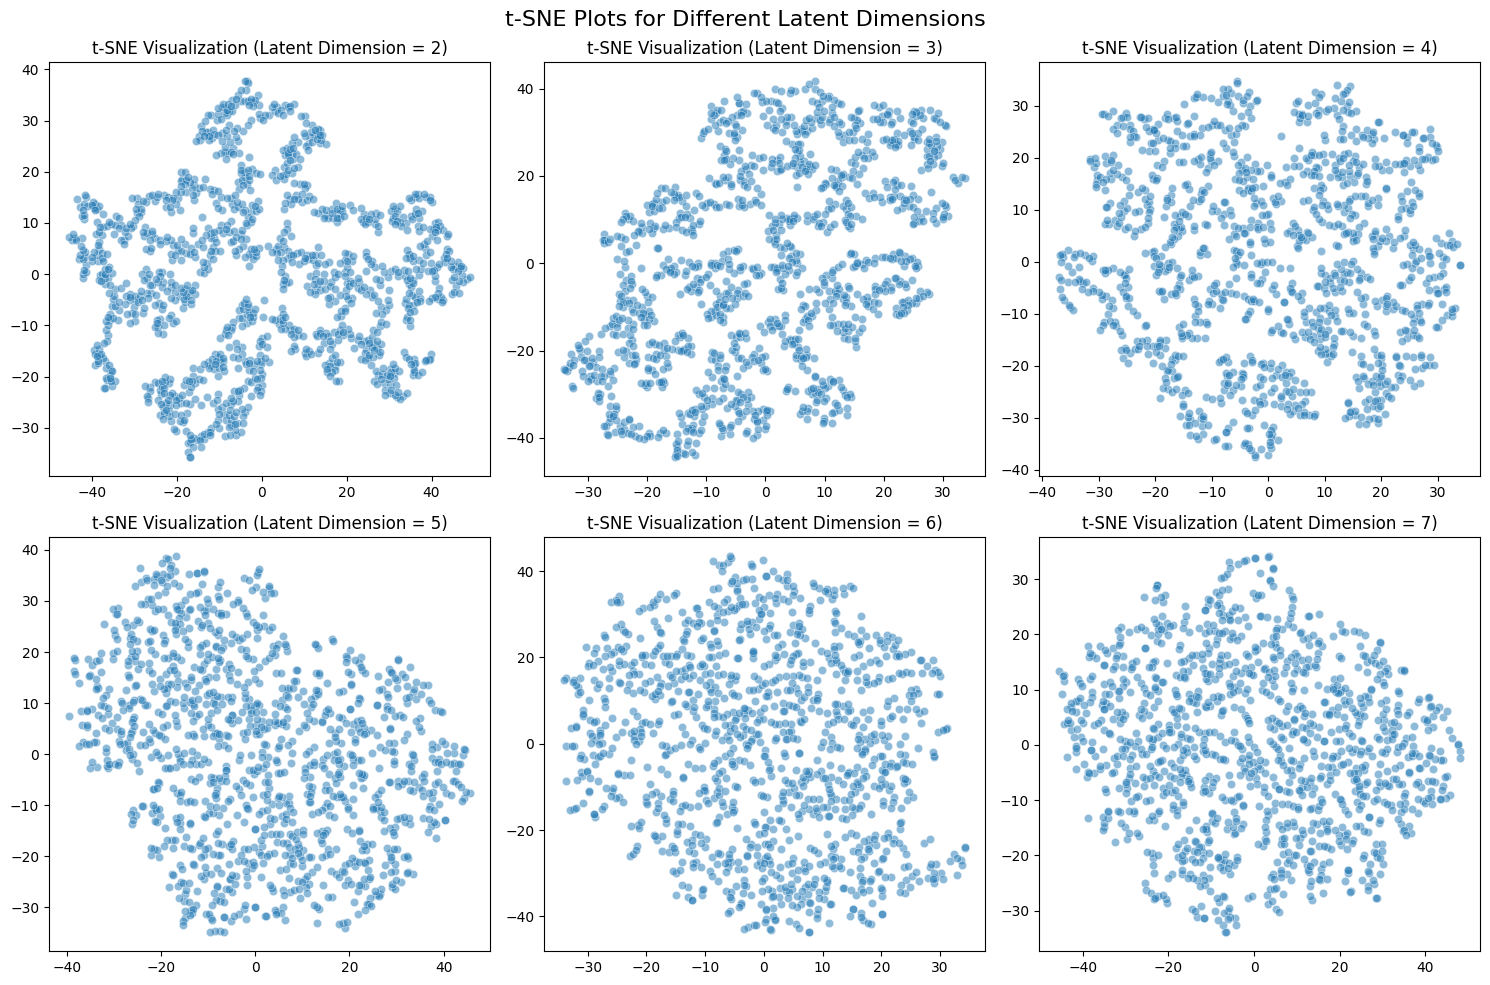

In [16]:
# plotting t-sne for each of the latent dimensions
plt.figure(figsize=(15, 10))

for i, d in enumerate(latent_dims):
    vae = vae_models[d]
    X_latent, _ = vae.encode(data_tensor.to(device))  # Extract only mean
    X_latent = X_latent.detach().cpu().numpy()  # Move to CPU and convert to NumPy

    # apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_latent)

    # plot
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], alpha=0.5)
    plt.title(f"t-SNE Visualization (Latent Dimension = {d})")

plt.suptitle("t-SNE Plots for Different Latent Dimensions", fontsize=16)
plt.tight_layout()
plt.show()

From the above plots, dimensions 2, 3 and 4 shows better seperation.

Elbow point for clusters for different dimensions

In [17]:
!pip install kneed


Processing Latent Dimension: 2
Latent Dimension 2 → Optimal k: 4

Processing Latent Dimension: 3
Latent Dimension 3 → Optimal k: 3

Processing Latent Dimension: 4
Latent Dimension 4 → Optimal k: 3

Processing Latent Dimension: 5
Latent Dimension 5 → Optimal k: 4

Processing Latent Dimension: 6
Latent Dimension 6 → Optimal k: 4

Processing Latent Dimension: 7
Latent Dimension 7 → Optimal k: 3


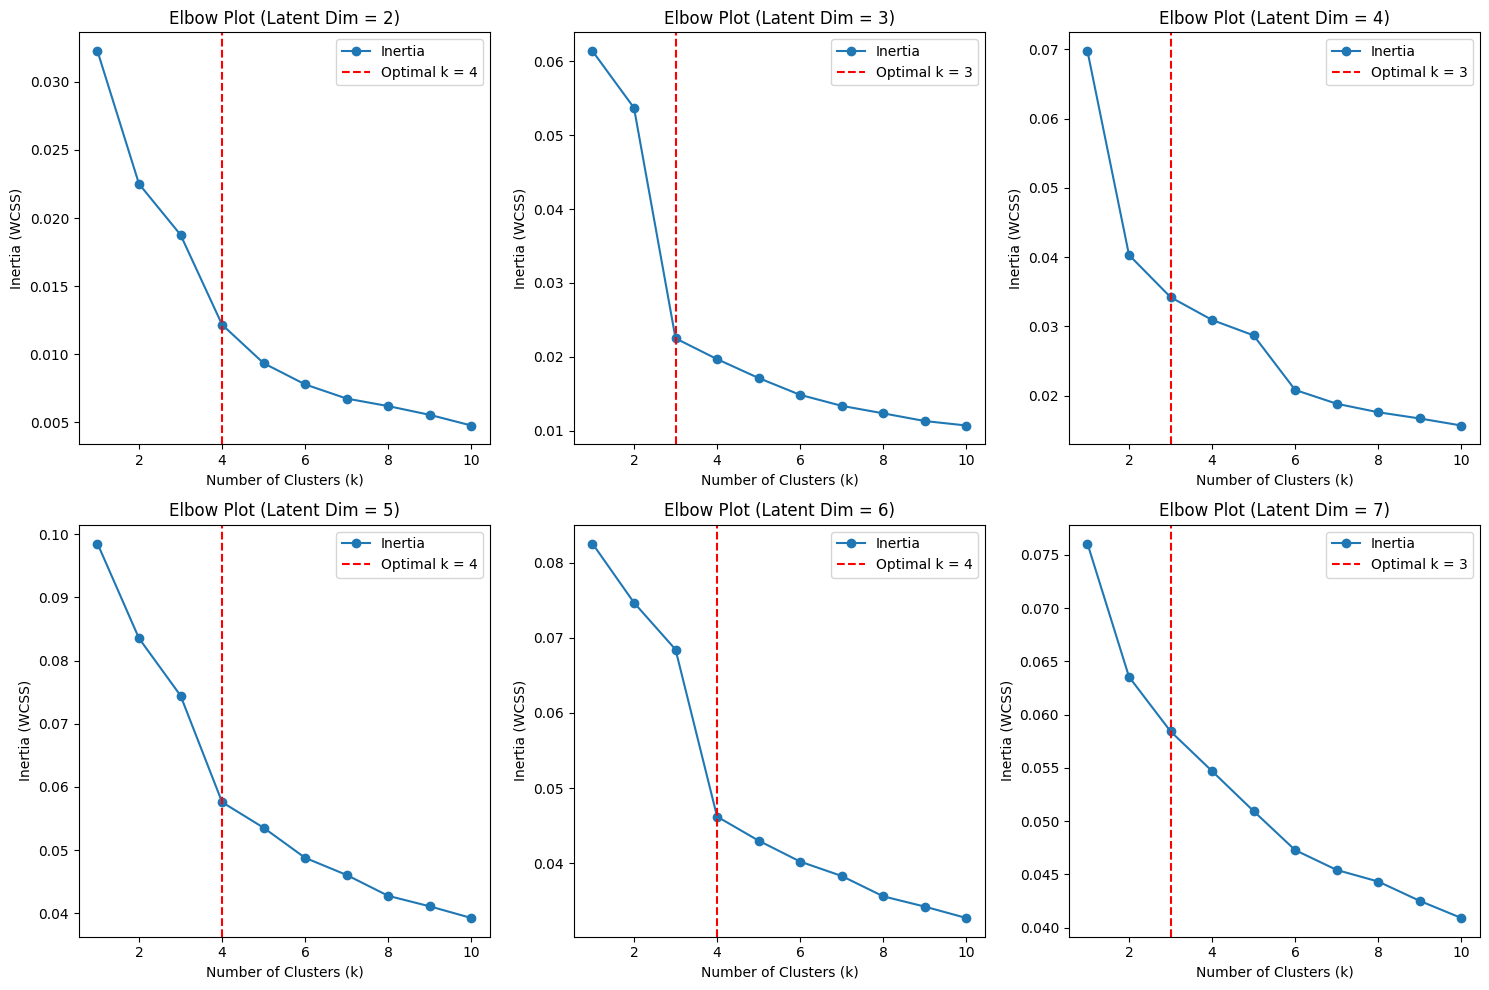

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

optimal_k_map = {} # storing the best k for different dimensions

def find_optimal_k_elbow(data, max_k=10, ax=None, dimension=None):    # method which finds the optimal k using the Elbow Method and plots the result.

    inertia = []
    k_values = range(1, max_k + 1) # trying out all values from 1 to maximum value for k

    for k in k_values:
        # Get the best KMeans clustering for the given k
        best_kmeans, _ = apply_kmeans_clustering(k, data)
        inertia.append(best_kmeans.inertia_)

    # Find elbow point automatically
    kneedle = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.elbow
    optimal_k_map[dimension] = optimal_k
    print(f"Latent Dimension {dimension} → Optimal k: {optimal_k}")

    # Plot the Elbow Method for this dimension
    ax.plot(k_values, inertia, marker='o', linestyle='-', label="Inertia")
    ax.axvline(optimal_k, linestyle="--", color="red", label=f"Optimal k = {optimal_k}")
    ax.set_xlabel("Number of Clusters (k)")
    ax.set_ylabel("Inertia (WCSS)")
    ax.set_title(f"Elbow Plot (Latent Dim = {dimension})")
    ax.legend()

# Create a 3×3 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easy iteration

latent_dims = range(2, 8)  # Latent dimensions from 2 to 9

for i, dimension in enumerate(latent_dims):
    print("\nProcessing Latent Dimension:", dimension)

    # Get latent representation
    vae = vae_models[dimension]
    mean, _ = vae.encode(data_tensor.to(device))  # Extract only mean
    latent_representations = mean.detach().cpu().numpy()

    # Call function with subplot axis
    find_optimal_k_elbow(latent_representations, ax=axes[i], dimension=dimension)

plt.tight_layout()
plt.show()


In [19]:
optimal_k_map

{2: np.int64(4),
 3: np.int64(3),
 4: np.int64(3),
 5: np.int64(4),
 6: np.int64(4),
 7: np.int64(3)}

Silhouette score and DB index for k-means with different dimensions

In [20]:
def evaluate_clustering_quality(latent_representations): # function which evaluates the cluster quality
    best_k = None
    best_silhouette = -1
    best_db = float('inf')

    for k in range(2, 11):  # try K from 2 to 10
        kmeans, clusters = apply_kmeans_clustering(k, latent_representations)
        labels = kmeans.labels_
        sil_score = silhouette_score(latent_representations, labels)
        db_score = davies_bouldin_score(latent_representations, labels)
        print(f"k = {k}, Silhouette score = {sil_score}, DB Score: {db_score}")
        # store the best clustering results
        if sil_score > best_silhouette:
            best_k, best_silhouette, best_db = k, sil_score, db_score

    return best_k, best_silhouette, best_db

In [21]:
latent_dimensions = [2, 3, 4, 5, 6, 7]
silhouette_scores = []
db_scores = []

for dimension in latent_dimensions:

    vae = vae_models[dimension] # get latent representations from VAE
    mean, _ = vae.encode(data_tensor.to(device))
    latent_representations = mean.detach().cpu().numpy()
    print("Dimension ", dimension)
    best_k, sil_score, db_score = evaluate_clustering_quality(latent_representations) # getting the best silhouette and db scores for different dimensions
    print(f"Best Silhouette Score: {sil_score}, Best DB Score: {db_score}")
    silhouette_scores.append(sil_score)
    db_scores.append(db_score)


Dimension  2
k = 2, Silhouette score = 0.49136587977409363, DB Score: 0.9533189457492475
k = 3, Silhouette score = 0.2826535701751709, DB Score: 1.1521777944264813
k = 4, Silhouette score = 0.2881280481815338, DB Score: 0.8543675629244691
k = 5, Silhouette score = 0.3131135106086731, DB Score: 0.7549040114179149
k = 6, Silhouette score = 0.32218581438064575, DB Score: 0.7875943512703603
k = 7, Silhouette score = 0.3171449303627014, DB Score: 0.7930547019780981
k = 8, Silhouette score = 0.2981421649456024, DB Score: 0.8427730969760953
k = 9, Silhouette score = 0.2930010259151459, DB Score: 0.8269025693035336
k = 10, Silhouette score = 0.3105490207672119, DB Score: 0.7812440708724695
Best Silhouette Score: 0.49136587977409363, Best DB Score: 0.9533189457492475
Dimension  3
k = 2, Silhouette score = 0.2635901868343353, DB Score: 1.4579233500794193
k = 3, Silhouette score = 0.24911481142044067, DB Score: 0.9696224243635373
k = 4, Silhouette score = 0.24683354794979095, DB Score: 0.87682228

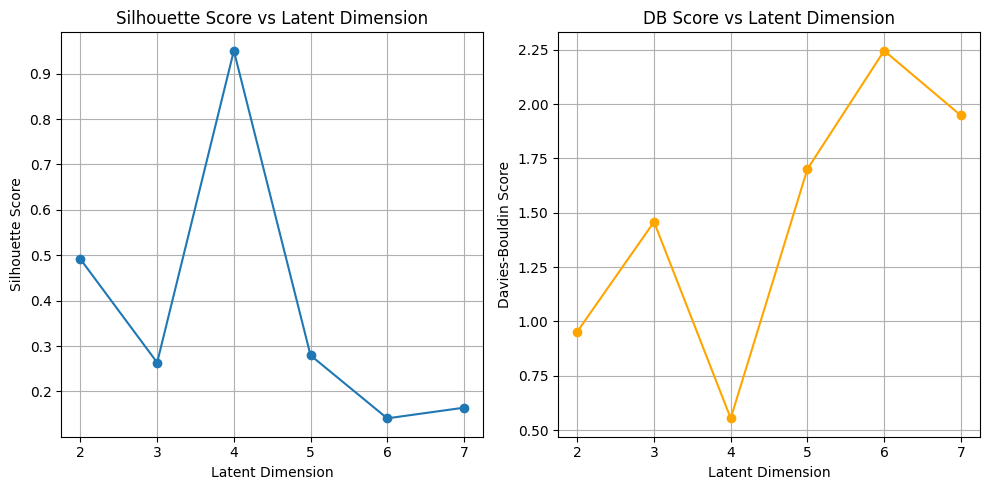

In [22]:
plt.figure(figsize=(10, 5)) # visualization

plt.subplot(1, 2, 1)
plt.plot(latent_dims, silhouette_scores, marker='o', label='Silhouette Score') # plotting silhouette score vs latent dimensions
plt.title("Silhouette Score vs Latent Dimension")
plt.xlabel("Latent Dimension")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(latent_dims, db_scores, marker='o', color='orange', label='Davies-Bouldin Score') # plotting db scores vs latent dimensions
plt.title("DB Score vs Latent Dimension")
plt.xlabel("Latent Dimension")
plt.ylabel("Davies-Bouldin Score")
plt.grid(True)

plt.tight_layout()
plt.show()


Higher the silhouette score the better and lower the DB score the better. Hence, dimension 4 shows better performance.

From the above analysis, the best dimensions to be reduced is would be 3, 4 or 5. The corresponding best number of clusters are 3, 3 and 4. Hence, reducing dimension to 3, 4 and 5 and applying kmeans with corresponding best k. Then taking the commonly appearing indices as outliers.

In [23]:
outlier_map = {} # to store outlier indices

Outlier detection with latent dimension set to 3

In [24]:
latent_dimension = 3  # setting the latent dimension to the selected best dimension
epochs = 50
num_clusters = optimal_k_map[3]

#  train using VAE and reduce dimension
vae1, avg_loss, avg_recon_loss, avg_kl_div = train_using_vae_and_compress_dimension(data_tensor, num_features, latent_dimension, epochs, True) # train the vae and compress dimensions

# saving the latent space representations
mean, log_variance = vae1.encode(data_tensor.to(device))
latent_representations1 = mean.cpu().detach().numpy()

# apply k-means clustering
kmeans1, clusters1 = apply_kmeans_clustering(num_clusters, latent_representations1)

# finding outliers
outlier_indices1, boundary_outliers1, small_cluster_outliers1 = identify_outliers(latent_representations1, kmeans1, clusters1)

outlier_map[3] = outlier_indices1

Epoch 0, Loss: 22.711735486984253
Epoch 1, Loss: 20.147254049777985
Epoch 2, Loss: 19.107613444328308
Epoch 3, Loss: 18.979823172092438
Epoch 4, Loss: 18.931526958942413
Epoch 5, Loss: 18.946161687374115
Epoch 6, Loss: 18.93233686685562
Epoch 7, Loss: 18.92629885673523
Epoch 8, Loss: 18.914229214191437
Epoch 9, Loss: 18.912851631641388
Epoch 10, Loss: 18.899706184864044
Epoch 11, Loss: 18.89961415529251
Epoch 12, Loss: 18.89999771118164
Epoch 13, Loss: 18.902226090431213
Epoch 14, Loss: 18.902288377285004
Epoch 15, Loss: 18.91212660074234
Epoch 16, Loss: 18.912247240543365
Epoch 17, Loss: 18.908439815044403
Epoch 18, Loss: 18.899312376976013
Epoch 19, Loss: 18.89887684583664
Epoch 20, Loss: 18.901366889476776
Epoch 21, Loss: 18.899961531162262
Epoch 22, Loss: 18.899463713169098
Epoch 23, Loss: 18.90073174238205
Epoch 24, Loss: 18.90188157558441
Epoch 25, Loss: 18.8966007232666
Epoch 26, Loss: 18.895929396152496
Epoch 27, Loss: 18.89964747428894
Epoch 28, Loss: 18.898114681243896
Epoch 

Outlier detection with latent dimension set to 4

In [25]:
latent_dimension = 4  # setting the latent dimension to the selected best dimension
epochs = 50
num_clusters = optimal_k_map[4]

#  train using VAE and reduce dimension
vae2, avg_loss, avg_recon_loss, avg_kl_div = train_using_vae_and_compress_dimension(data_tensor, num_features, latent_dimension, epochs, True) # train the vae and compress dimensions

# saving the latent space representations
mean, log_variance = vae2.encode(data_tensor.to(device))
latent_representations2 = mean.cpu().detach().numpy()

# apply k-means clustering
kmeans2, clusters2 = apply_kmeans_clustering(num_clusters, latent_representations2)

# finding outliers
outlier_indices2, boundary_outliers2, small_cluster_outliers2 = identify_outliers(latent_representations2, kmeans2, clusters2)

outlier_map[4] = outlier_indices2

Epoch 0, Loss: 22.871602654457092
Epoch 1, Loss: 20.30757975578308
Epoch 2, Loss: 19.092848300933838
Epoch 3, Loss: 18.967982053756714
Epoch 4, Loss: 18.94172477722168
Epoch 5, Loss: 18.941598534584045
Epoch 6, Loss: 18.961900055408478
Epoch 7, Loss: 18.961154580116272
Epoch 8, Loss: 18.93402135372162
Epoch 9, Loss: 18.902997076511383
Epoch 10, Loss: 18.897943794727325
Epoch 11, Loss: 18.907948791980743
Epoch 12, Loss: 18.901096522808075
Epoch 13, Loss: 18.899146795272827
Epoch 14, Loss: 18.89844185113907
Epoch 15, Loss: 18.893163561820984
Epoch 16, Loss: 18.899920284748077
Epoch 17, Loss: 18.8988578915596
Epoch 18, Loss: 18.90062928199768
Epoch 19, Loss: 18.901229798793793
Epoch 20, Loss: 18.902289867401123
Epoch 21, Loss: 18.903602838516235
Epoch 22, Loss: 18.905795454978943
Epoch 23, Loss: 18.90709912776947
Epoch 24, Loss: 18.905158936977386
Epoch 25, Loss: 18.902119398117065
Epoch 26, Loss: 18.901806235313416
Epoch 27, Loss: 18.900484323501587
Epoch 28, Loss: 18.89606124162674
Epoc

Outlier detection with latent dimension set to 5

In [26]:
latent_dimension = 5  # setting the latent dimension to the selected best dimension
epochs = 50
num_clusters = optimal_k_map[5]

#  train using VAE and reduce dimension
vae3, avg_loss, avg_recon_loss, avg_kl_div = train_using_vae_and_compress_dimension(data_tensor, num_features, latent_dimension, epochs, True) # train the vae and compress dimensions

# saving the latent space representations
mean, log_variance = vae3.encode(data_tensor.to(device))
latent_representations3 = mean.cpu().detach().numpy()

# apply k-means clustering
kmeans3, clusters3 = apply_kmeans_clustering(num_clusters, latent_representations3)

# finding outliers
outlier_indices3, boundary_outliers3, small_cluster_outliers3 = identify_outliers(latent_representations3, kmeans3, clusters3)

outlier_map[5] = outlier_indices3

Epoch 0, Loss: 23.06146639585495
Epoch 1, Loss: 20.109313309192657
Epoch 2, Loss: 19.11086857318878
Epoch 3, Loss: 18.995614171028137
Epoch 4, Loss: 18.963444471359253
Epoch 5, Loss: 18.939114212989807
Epoch 6, Loss: 18.933101773262024
Epoch 7, Loss: 18.91901832818985
Epoch 8, Loss: 18.91928380727768
Epoch 9, Loss: 18.918486177921295
Epoch 10, Loss: 18.909323155879974
Epoch 11, Loss: 18.926757872104645
Epoch 12, Loss: 18.910615742206573
Epoch 13, Loss: 18.910803198814392
Epoch 14, Loss: 18.917974710464478
Epoch 15, Loss: 18.9030042886734
Epoch 16, Loss: 18.9057257771492
Epoch 17, Loss: 18.916797876358032
Epoch 18, Loss: 18.937092900276184
Epoch 19, Loss: 18.936599552631378
Epoch 20, Loss: 18.90998339653015
Epoch 21, Loss: 18.905937254428864
Epoch 22, Loss: 18.898581326007843
Epoch 23, Loss: 18.900420308113098
Epoch 24, Loss: 18.897447109222412
Epoch 25, Loss: 18.901371717453003
Epoch 26, Loss: 18.902272582054138
Epoch 27, Loss: 18.89630287885666
Epoch 28, Loss: 18.896148681640625
Epoch

Common indices from these:


In [27]:
from collections import Counter

# Flatten all values into a single list
all_indices = [idx for sublist in outlier_map.values() for idx in sublist]

# Count occurrences of each index
index_counts = Counter(all_indices)

# Find indices that appear at least three times
common_indices = [idx for idx, count in index_counts.items() if count > 1]

common_indices = [int(idx) for idx in common_indices]

common_indices.sort()
final_outlier_indices = common_indices



Outliers printed

In [28]:
print("Number of common outliers: ", len(final_outlier_indices))
print("Final indices are:", final_outlier_indices)

Number of common outliers:  30
Final indices are: [3, 5, 25, 30, 66, 67, 102, 106, 202, 206, 209, 219, 249, 251, 263, 299, 314, 351, 420, 471, 509, 527, 591, 852, 892, 966, 986, 1019, 1035, 1077]


In [29]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.expand_frame_repr", False)
# Show all rows
pd.set_option("display.max_rows", None)

print(data_frame.iloc[final_outlier_indices])

          cov1      cov2      cov3      cov4      cov5      cov6      cov7  sal_pur_rat  igst_itc_tot_itc_rat  lib_igst_itc_rat
3     0.396577  0.919933  0.496451  0.576824 -0.340718  0.802363  0.673710    -0.032058              0.449160         -0.054126
5     0.595378 -0.531958  0.679654 -0.126799  0.455487  0.432046  0.988092    -0.029813              0.768742         -0.054167
25    0.310202  0.714827  0.999397  0.450586  0.999196  0.951493  0.994530     3.957174             -0.567733         -0.042841
30    0.988148  0.999722 -0.263888 -0.341572  0.904135  0.880853  0.931499    -0.032029              0.249506         -0.054218
66    0.931183  0.999999  0.595929  0.590790  0.839027  0.399217  0.866698    -0.030785             -0.253276         -0.053778
67    0.995120  0.495787  0.427310 -0.133896  0.511221  0.274859  0.987462    -0.031382              1.563899         -0.054286
102   0.999988  0.998002 -0.263647 -0.279467  0.000000  0.490375  0.356098    -0.033177             -1.0

Verification of outliers using z-score method

In [30]:
import pandas as pd
import numpy as np

def detect_outliers_zscore(df, threshold=4):   # function which detects outlier rows in a DataFrame using the Z-score method.

    z_scores = np.abs((df - df.mean()) / df.std())  # Compute Z-scores
    outlier_mask = (z_scores > threshold).any(axis=1)  # Identify rows with any Z-score above the threshold
    return df[outlier_mask]  # Return outlier rows


df = data_frame

outliers = detect_outliers_zscore(df)

print("Outlier Indices:", outliers.index.tolist()) # Print the indices of the outlier rows




Outlier Indices: [3, 5, 13, 25, 30, 37, 45, 59, 66, 74, 77, 82, 102, 106, 115, 201, 202, 206, 209, 232, 235, 249, 251, 260, 308, 309, 314, 332, 362, 392, 408, 432, 462, 471, 488, 502, 509, 510, 527, 591, 596, 603, 608, 611, 638, 720, 852, 899, 957, 979, 986, 1035, 1094, 1141, 1167]


Verification of outliers using isolation forest

In [31]:
import pandas as pd
from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(df, contamination=0.04): # function which detects outliers using isolation forest algorithm

    model = IsolationForest(contamination=contamination, random_state=42)
    df['anomaly'] = model.fit_predict(df)
    outliers = df[df['anomaly'] == -1].drop(columns=['anomaly'])  # Keep only outliers
    return outliers

df = data_frame

outliers = detect_outliers_isolation_forest(df)

print("Outlier Indices:", outliers.index.tolist()) # print the outlier indices


Outlier Indices: [5, 13, 25, 37, 45, 59, 65, 74, 82, 106, 136, 141, 201, 202, 209, 219, 235, 243, 249, 251, 260, 263, 278, 308, 314, 332, 351, 356, 392, 432, 453, 462, 471, 495, 527, 591, 606, 608, 611, 638, 763, 834, 852, 899, 979, 1035, 1065, 1141]


Comparing the indices of the outliers obtained using z-score and isolation forest with the outliers obtained using VAE dimension reduction and k-means, it can be seen that most of the indices are the same. Hence, the method has identified the outliers succesfully.